# Model-Based Curation Tutorial: Applying Models to Pre-computed Metrics


This tutorial demonstrates how to apply pre-trained machine learning models for spike sorting curation using pre-computed quality metrics stored in CSV files. This workflow is ideal when you have existing quality metrics from previous analyses and want to apply automated curation without recomputing all metrics.

In [ ]:
! pip install spikeinterface[full]

In [ ]:
import spikeinterface as si
import spikeinterface.curation as sc
import spikeinterface.widgets as sw

print(f"SpikeInterface version: {si.__version__}")

SpikeInterface version: 0.102.3


UnitRefine includes dedicated pre-trained models for different curation tasks, such as removing noisy units and indetiftyng SUA

Models can be loaded directly from the Hugging Face Hub or from local files. The load_model function automatically handles both and returns the model together with its metadata.

Below is an example using a small demo noise-classifier model from Hugging Face, trained to identify units dominated by noise or artifacts.


In [3]:
model, model_info = sc.load_model(
    repo_id = "SpikeInterface/UnitRefine_noise_neural_classifier",
    trusted = ['numpy.dtype']
)

c:\Users\jain\Anaconda3\envs\py311-env\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.4.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\jain\Anaconda3\envs\py311-env\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\jain\Anaconda3\envs\py311-env\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.4.2 when

In [4]:
print("Model Structure:")
print(f"Pipeline steps: {[step[0] for step in model.steps]}")
print(f"Final estimator: {model.steps[-1][1].__class__.__name__}")

Model Structure:
Pipeline steps: ['imputer', 'scaler', 'classifier']
Final estimator: RandomForestClassifier


### Understanding Feature Requirements

Each model requires certain quality metrics to make predictions. Let’s check which metrics this model needs to run predictions on new data. 

In [6]:
required_features = model.feature_names_in_
print("Required Quality Metrics: ", required_features)

print(f"\nTotal features required: {len(required_features)}")
        
print(f"\nLabel conversion: {model_info.get('label_conversion', 'Not specified')}")

Required Quality Metrics:  ['amplitude_cutoff' 'amplitude_cv_median' 'amplitude_cv_range'
 'amplitude_median' 'drift_ptp' 'drift_std' 'drift_mad' 'firing_range'
 'firing_rate' 'isi_violations_ratio' 'isi_violations_count' 'num_spikes'
 'presence_ratio' 'rp_contamination' 'rp_violations'
 'sliding_rp_violation' 'snr' 'sync_spike_2' 'sync_spike_4' 'sync_spike_8'
 'd_prime' 'isolation_distance' 'l_ratio' 'silhouette' 'nn_hit_rate'
 'nn_miss_rate' 'exp_decay' 'half_width' 'num_negative_peaks'
 'num_positive_peaks' 'peak_to_valley' 'peak_trough_ratio'
 'recovery_slope' 'repolarization_slope' 'spread' 'velocity_above'
 'velocity_below']

Total features required: 37

Label conversion: {'0': 'neural', '1': 'noise'}


# Load your metrics files

In [7]:
import pandas as pd

# Load your files
metrics =  pd.read_csv('all_metrics.csv')

In [8]:
columns = model.feature_names_in_

classifier_preds = model.predict(metrics[columns])
classifier_probabs = model.predict_proba(metrics[columns])

In [9]:
print(pd.Series(classifier_preds).map({1: 'noise', 0: 'neural'}))


0       noise
1       noise
2       noise
3       noise
4       noise
        ...  
555    neural
556    neural
557     noise
558    neural
559    neural
Length: 560, dtype: object


## Visualizing Classification Results

Let's create a simple visualization to understand our model's predictions and confidence levels.

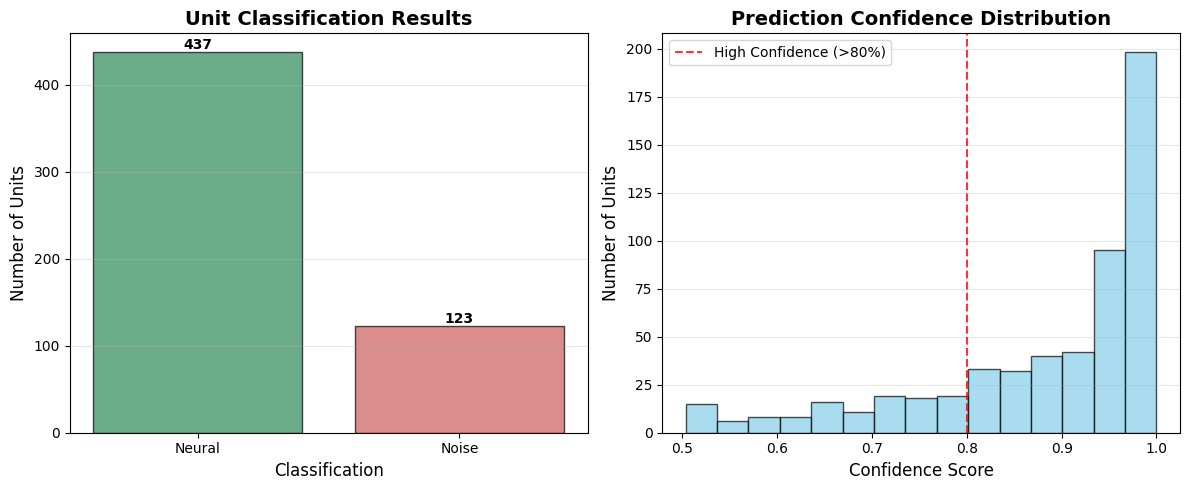

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Create a simple visualization of the classification results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Convert predictions to readable labels
pred_labels = pd.Series(classifier_preds).map({1: 'Noise', 0: 'Neural'})
label_counts = pred_labels.value_counts()

# Plot 1: Classification Results Distribution
colors = ['#2E8B57', '#CD5C5C']  # Green for Neural, Red for Noise
bars = ax1.bar(label_counts.index, label_counts.values, color=colors, alpha=0.7, edgecolor='black')
ax1.set_title('Unit Classification Results', fontsize=14, fontweight='bold')
ax1.set_xlabel('Classification', fontsize=12)
ax1.set_ylabel('Number of Units', fontsize=12)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')

# Plot 2: Prediction Confidence Distribution
max_confidences = np.max(classifier_probabs, axis=1)
ax2.hist(max_confidences, bins=15, color='skyblue', alpha=0.7, edgecolor='black')
ax2.axvline(x=0.8, color='red', linestyle='--', alpha=0.8, label='High Confidence (>80%)')
ax2.set_title('Prediction Confidence Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Confidence Score', fontsize=12)
ax2.set_ylabel('Number of Units', fontsize=12)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()